## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0716 11:03:00.707858 139965497173888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0716 11:03:00.710359 139965497173888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0716 11:03:00.757243 139965497173888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 11:03:00.759989 139965497173888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W071

Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0716 11:03:01.120859 139965497173888 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 132us/step - loss: 197.7905 - acc: 0.2418 - val_loss: 36.0531 - val_acc: 0.2555
Epoch 2/50
50000/50000 [==============================] - 3s 58us/step - loss: 15.9535 - acc: 0.1104 - val_loss: 5.1346 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.2145 - acc: 0.0983 - val_loss: 2.4723 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.4633 - acc: 0.0986 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.4624 - acc: 0.0987 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4624 - acc: 0.0988 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.4624 - acc: 0.0967 - val_loss: 2.4623 - va

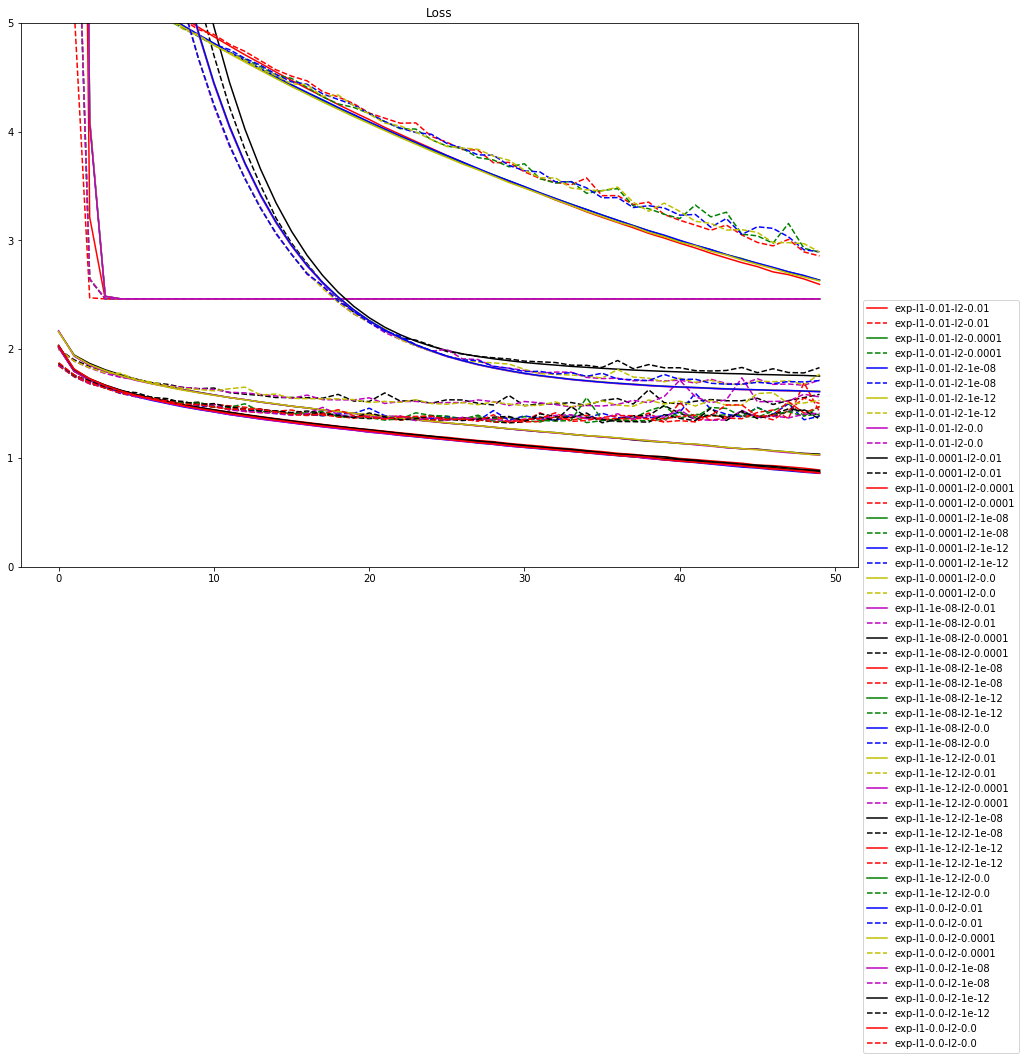

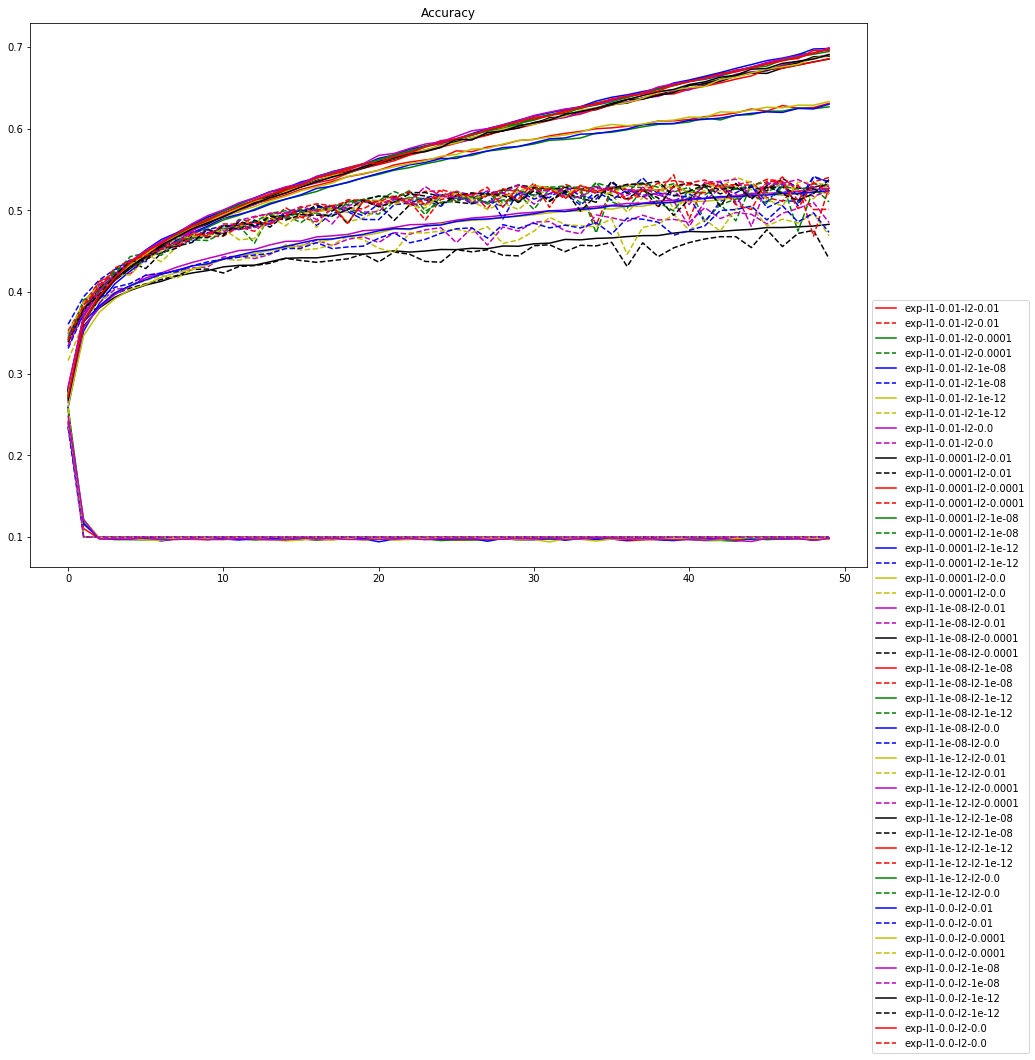

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]
cn = len(color_bar)

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i % cn])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i % cn])
plt.title("Loss")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.ylim([0, 5])
#plt.legend()
plt.show()

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i % cn])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i % cn])
plt.title("Accuracy")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
#plt.legend()
plt.show()

In [9]:
results.keys()

dict_keys(['exp-l1-0.01-l2-0.01', 'exp-l1-0.01-l2-0.0001', 'exp-l1-0.01-l2-1e-08', 'exp-l1-0.01-l2-1e-12', 'exp-l1-0.01-l2-0.0', 'exp-l1-0.0001-l2-0.01', 'exp-l1-0.0001-l2-0.0001', 'exp-l1-0.0001-l2-1e-08', 'exp-l1-0.0001-l2-1e-12', 'exp-l1-0.0001-l2-0.0', 'exp-l1-1e-08-l2-0.01', 'exp-l1-1e-08-l2-0.0001', 'exp-l1-1e-08-l2-1e-08', 'exp-l1-1e-08-l2-1e-12', 'exp-l1-1e-08-l2-0.0', 'exp-l1-1e-12-l2-0.01', 'exp-l1-1e-12-l2-0.0001', 'exp-l1-1e-12-l2-1e-08', 'exp-l1-1e-12-l2-1e-12', 'exp-l1-1e-12-l2-0.0', 'exp-l1-0.0-l2-0.01', 'exp-l1-0.0-l2-0.0001', 'exp-l1-0.0-l2-1e-08', 'exp-l1-0.0-l2-1e-12', 'exp-l1-0.0-l2-0.0'])

In [10]:
results['exp-l1-0.01-l2-0.01']['train-loss']

[197.79046083251953,
 15.953479185943603,
 3.2145008013916017,
 2.4632701193237305,
 2.462443010940552,
 2.462406606140137,
 2.4623616999053954,
 2.4623304257202148,
 2.4622817473602296,
 2.4622499200439454,
 2.462200551376343,
 2.4621522760772705,
 2.4621305213165283,
 2.4621045264434813,
 2.4620743123626707,
 2.4620562905883787,
 2.4620268565368653,
 2.461999776916504,
 2.4619926218414308,
 2.461966095504761,
 2.461964242477417,
 2.4619544355010987,
 2.461949767990112,
 2.4619291121673585,
 2.4619322373962405,
 2.4619148046875,
 2.4618986643981935,
 2.461886070251465,
 2.4618621629333495,
 2.4618423038482664,
 2.4618223399353028,
 2.4617784201049804,
 2.4617688969421385,
 2.461741318817139,
 2.46172747215271,
 2.46170293510437,
 2.4616777489471438,
 2.4616671333312987,
 2.4616419066619875,
 2.461613031692505,
 2.4615924839019776,
 2.4615803287506104,
 2.461554465942383,
 2.461526463470459,
 2.4615119567108152,
 2.4614767571258547,
 2.4614586461639405,
 2.4614459519195555,
 2.46141288